In [2]:
import pandas as pd
import numpy as np
import gensim
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity
from sklearn.decomposition import PCA
import matplotlib as mpl
import matplotlib.pyplot as plt


In [98]:
emb = gensim.models.doc2vec.Doc2Vec.load('../models/party_lvl-dm-m-d20-n5-w10-mc5-s0.001-t8.mdl')
#emb2 = gensim.models.doc2vec.Doc2Vec.load('../models/party_lvl-dm-m-d20-n5-w10-mc5-s0.001-t8-e10-bigrams-2tags-pp-psoe-only.mdl')
#emb2 = gensim.models.doc2vec.Doc2Vec.load('../models/party_lvl-dm-m-d300-n5-w20-mc5-s1e-6-t8-e100-bigrams-2tags-pp-psoe-only.mdl')

FileNotFoundError: [Errno 2] No such file or directory: '../models/party_lvl-dm-m-d20-n5-w10-mc5-s0.001-t8.mdl'

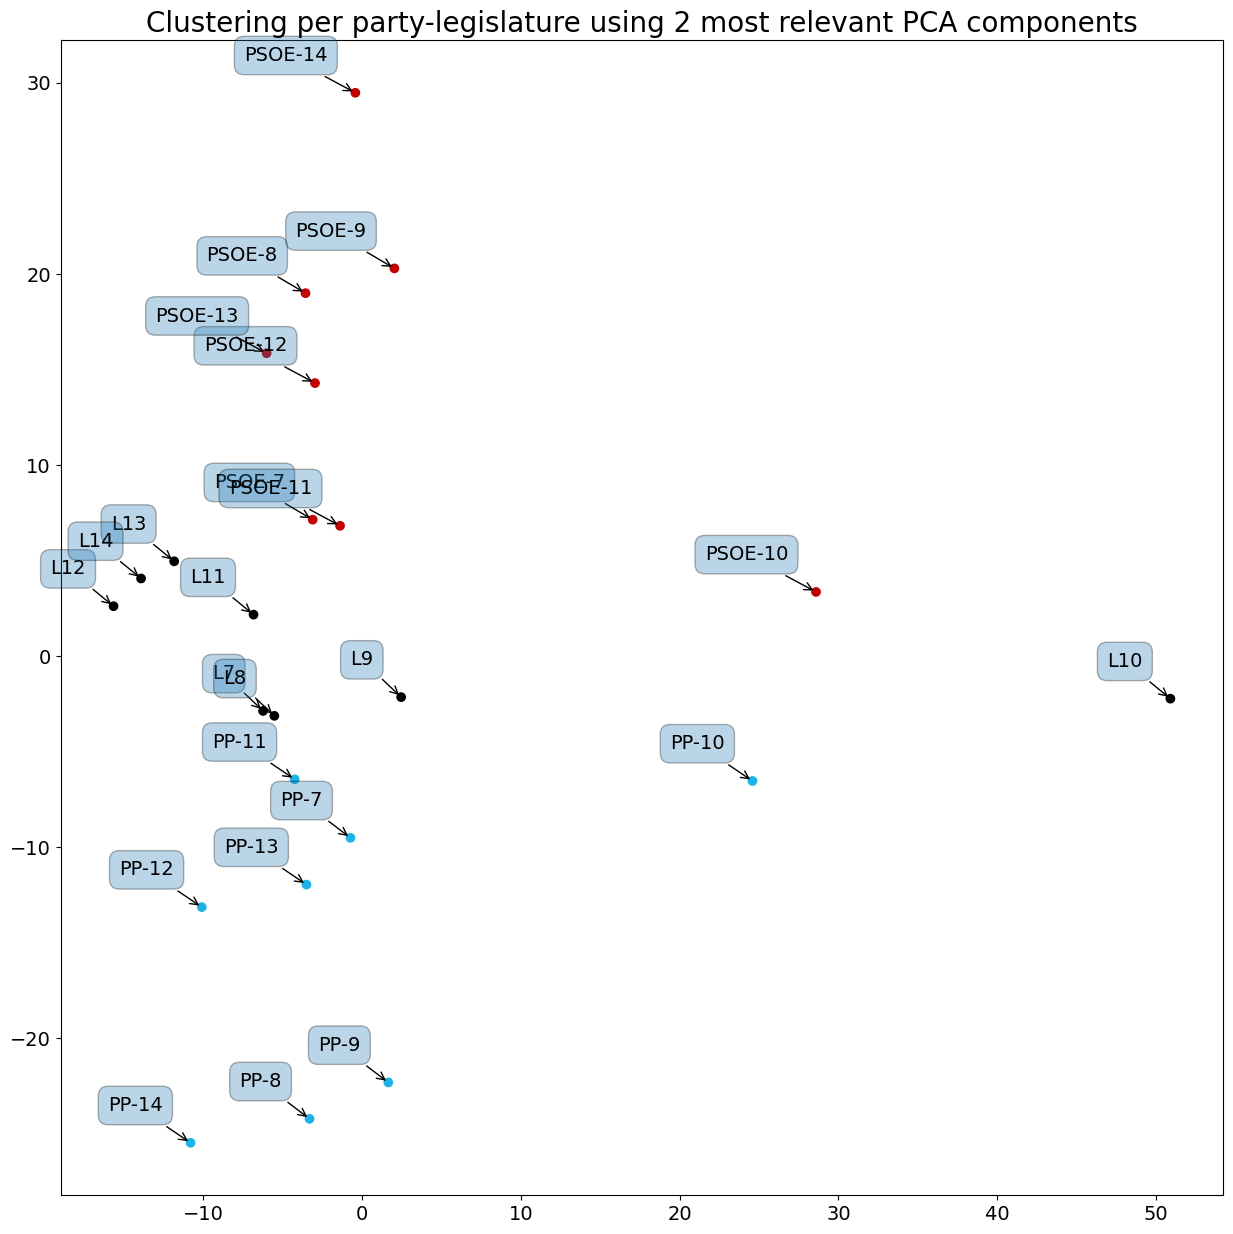

In [94]:
def reduce_dimension(model, n=2):
    speakers = [item for item in model.dv.index_to_key] #if '-' in item]
    S = len(speakers)
    M = model.vector_size
    z = np.zeros((S, M))

    for i in range(S):
        z[i, :] = model.dv[i]

    dr = PCA(n_components=n)
    Z = dr.fit_transform(z)

    Z = pd.DataFrame(Z)

    columns = []
    for i in range(n):
        columns.append(f'dim{i}')
    Z.columns = columns

    Z['speaker'] = speakers

    return Z, dr

def get_color(reduced):
    spk = reduced.speaker.tolist()
    col = []
    for i in range(len(spk)):
        if 'VOX' in spk[i]:
            # #82b431
            # rgba(130,180,49,255)
            col.append('#82b431')
        elif 'PSOE' in spk[i]:
            # #c10200
            # rgba(193,2,0,255)
            col.append('#c10200')
        elif 'IU' in spk[i]:
            # #c10200
            # rgba(193,2,0,255)
            col.append('#8b0000')
        elif 'CS' in spk[i]:
            # #f87729
            # rgba(248,119,41,255)
            col.append('#f87729')
        elif 'PP' in spk[i]:
            # #1eb3e6
            # rgba(30,179,230,255)
            col.append('#1eb3e6')
        elif 'UP' in spk[i]:
            # #a245b2
            # rgba(162,69,178,255)
            col.append('#a245b2')
        elif 'ERC' in spk[i]:
            # #f99f00
            # rgba(249,159,0,255)
            col.append('#f99f00')
        elif 'PNV' in spk[i]:
            # #008146
            # rgba(0,129,70,255)
            col.append('#008146')
        elif 'EHB' in spk[i]:
            # #bbce00
            # rgba(187,206,0,255)
            col.append('#bbce00')
        else:
            col.append('#000000')

    reduced['col'] = col
    return reduced

def plot(reduced):
    mpl.rcParams['axes.titlesize'] = 20
    mpl.rcParams['axes.labelsize'] = 20
    mpl.rcParams['font.size'] = 14

    plt.figure(figsize=(15, 15))
    plt.scatter(reduced.dim0, reduced.dim1, c=reduced.col)
    texts = []

    for label, x, y in zip(reduced.speaker, reduced.dim0, reduced.dim1):
        plt.annotate(
            label,
            xy=(x, y), xytext=(-20, 20),
            textcoords='offset points', ha='right', va='bottom',
            bbox=dict(boxstyle='round,pad=0.5', alpha=0.3),
            arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

    plt.title(
        'Clustering per party-legislature using 2 most relevant PCA components')
    plt.show()

Z, dr = reduce_dimension(emb)
reduced = get_color(Z)
plot(reduced)

In [97]:
reduced.min()



dim0      -15.655793
dim1      -25.476971
speaker          L10
col          #000000
dtype: object

In [95]:
def interpret(emb, pca, N, min_count, max_count, topn) -> list:
    
    # List all the tokens sorted by ocurrence in the corpus.
    words = emb.wv.index_to_key

    max = reduced.max()
    min = reduced.min()

    wl = []
    for w in words:
        wl.append((w, emb.wv.get_vecattr(w, 'count')))
    
    selected_wl = [word for word, c in wl if c > min_count and c < max_count]

    if len(selected_wl) < N:
        N = len(selected_wl)
        print(f'Size of selected_wl is smaller than N. N is now = {N}')

    selected_wl = selected_wl[0:N]

    # Reduce the vectors for each selected word using the PCA model to a 2D vector.
    M = np.zeros((N, 2))
    for i, w in enumerate(selected_wl):
        M[i, :] = pca.transform(emb.wv[w].reshape(1, -1))

    # Compute euclidean distances to each corner of the reduced embedding space.
    right = euclidean_distances(M, np.array([max[0], 0]).reshape(1, -1))
    left = euclidean_distances(M, np.array([min[0], 0]).reshape(1, -1))
    up = euclidean_distances(M, np.array([0, max[1]]).reshape(1, -1))
    down = euclidean_distances(M, np.array([0, min[1]]).reshape(1, -1))

    similarities = pd.DataFrame({
        'word': selected_wl,
        'right': right[:, 0],
        'left': left[:, 0],
        'up': up[:, 0],
        'down': down[:, 0]})

    print('Words associated with possitive values of the first PCA component (right):')
    print(80*'-')
    print(similarities.sort_values(by='right')['word'].tolist()[0:topn])
    print('\n')

    print('Words associated with negative values of the first PCA component (left):')
    print(80*'-')
    print(similarities.sort_values(by='left')['word'].tolist()[0:topn])
    print('\n')

    print('Words associated with possitive values of the second PCA component (up):')
    print(80*'-')
    print(similarities.sort_values(by='up')['word'].tolist()[0:topn])
    print('\n')

    print('Words associated with negative values of the second PCA component (down):')
    print(80*'-')
    print(similarities.sort_values(by='down')['word'].tolist()[0:topn])
    print('\n')

interpret(emb2, dr, 10000, 200, 10000, 50)

Size of selected_wl is smaller than N. N is now = 7890
Words associated with possitive values of the first PCA component (right):
--------------------------------------------------------------------------------
['pl0', 'ción', 'ión_permanente_mbre_pág', 'siones_pág', 'mos', 'ión_permanente_pág', 'com', 'nte', 'siones_mbre_pág', 'ado', 'mente', 'ciones', 'ación', 'est', 'ión', 'izquierda_plural', 'nto', 'ara', 'ndo', 'des', 'pre', 'número_expediente', 'sta', 'dad', 'autónomas', 'res', 'seño', 'das', 'hurtado', 'ones', 'palabra', 'página', 'tra', 'nes', 'par', 'ente', 'prima_riesgo', 'upyd', 'pro', 'comis_núm_noviem', 'recortes', 'universidades', 'montoro', 'señ', 'villalobos_talero', 'básicos', 'pobreza', 'león', 'privatización', 'recortado']


Words associated with negative values of the first PCA component (left):
--------------------------------------------------------------------------------
['pionera', 'plan_hidrológico', 'pandemia', 'contingente', 'podía_ser', 'presidencia_español

In [99]:
#s = ['empresas', 'libertad', 'beneficios', 'privado']
s = ['terrorista']
infer_vector = emb2.infer_vector(s)
similar_documents = emb2.dv.most_similar([infer_vector], topn=10)
similar_documents


[('L11', 0.42534691095352173),
 ('L9', 0.4023926258087158),
 ('L8', 0.39780810475349426),
 ('L13', 0.27999794483184814),
 ('PP-7', 0.2688468396663666),
 ('L14', 0.2600586712360382),
 ('L12', 0.25852110981941223),
 ('PP-13', 0.24418114125728607),
 ('L10', 0.17702196538448334),
 ('PP-11', 0.16712552309036255)]

In [104]:
emb2.wv.similar_by_vector(
    emb2.dv['PSOE-14'], topn=100, restrict_vocab=20000)

[('derecha', 0.6573715209960938),
 ('ultraderecha', 0.5562635660171509),
 ('abascal', 0.519913375377655),
 ('gamarra', 0.5148540735244751),
 ('progresista', 0.5134629011154175),
 ('derecha_ultraderecha', 0.4969841241836548),
 ('casado', 0.48598355054855347),
 ('teléf_fax', 0.48247528076171875),
 ('imprime_distribuye_mprenta_nacional', 0.4722890853881836),
 ('ciudadanía', 0.471537321805954),
 ('arrimadas', 0.4701056182384491),
 ('edita_calle_floridablanca_madrid', 0.46448540687561035),
 ('derechas', 0.46296632289886475),
 ('boe_avenida_manoteras_madrid', 0.4605594277381897),
 ('trabajadores_trabajadoras', 0.45692601799964905),
 ('nadie_quede_atrás', 0.4560542404651642),
 ('coalición_progresista', 0.4534461796283722),
 ('http_www', 0.4509894549846649),
 ('clase_media_trabajadora', 0.439458966255188),
 ('plan_recuperación_transformación', 0.4326407015323639),
 ('ruido', 0.4209621846675873),
 ('españoles_españolas', 0.42042407393455505),
 ('reforzando', 0.41907012462615967),
 ('hacia', 0.4

In [101]:
emb2.wv.most_similar(positive=['rey'], topn=20)

[('majestad_rey', 0.8064596056938171),
 ('majestad', 0.7437318563461304),
 ('corona', 0.7019537091255188),
 ('golpista', 0.6845688819885254),
 ('umd', 0.6817938089370728),
 ('tarradellas', 0.6793130040168762),
 ('casa_majestad_rey', 0.6789883971214294),
 ('sueldo_rey', 0.6753228902816772),
 ('hitler', 0.6724854111671448),
 ('salón', 0.6663691401481628),
 ('monarquía', 0.664530873298645),
 ('juramento', 0.6631643772125244),
 ('repúblicas', 0.6579472422599792),
 ('tito', 0.6465358734130859),
 ('republicana', 0.6429462432861328),
 ('cantidad_global_sostenimiento', 0.6428518295288086),
 ('jordi_solé_tura', 0.6411094665527344),
 ('gracia_dios', 0.6349351406097412),
 ('marqués', 0.6346961855888367),
 ('picasso', 0.6301681995391846)]